# Training 3D U-Net model for multi-class semantic segmentation

### Install pkgs

In [24]:
#!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
#!pip install -q "monai-weekly[mlflow]"

In [ ]:
# Make a copick project
import os
import shutil

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "/kaggle/working/copick.config"
output_overlay = "/kaggle/working/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = '/kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = '/kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

In [14]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

## Prepare the dataset

### 1. Get copick root

In [2]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

### 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [5]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()
        target = np.zeros(tomo.shape, dtype=np.uint8)
        for pickable_object in root.pickable_objects:
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            if len(pick):  
                target = segmentation_from_picks.from_picks(pick[0], 
                                                            target, 
                                                            target_objects[pickable_object.name]['radius'] * 0.8,
                                                            target_objects[pickable_object.name]['label']
                                                            )
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)



### 3. Get tomograms and their segmentaion masks (from picks) arrays

This 10439 dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [3]:
data_dicts = []
for run in tqdm(root.runs):
    tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
    segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
    data_dicts.append({"image": tomogram, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|██████████| 7/7 [01:10<00:00, 10.07s/it]


Since memebranes do not have picks, we should see 6 distinct labels for particles, with 0 being the default background label. 

### 4. Visualize the tomogram and painted segmentation from ground-truth picks

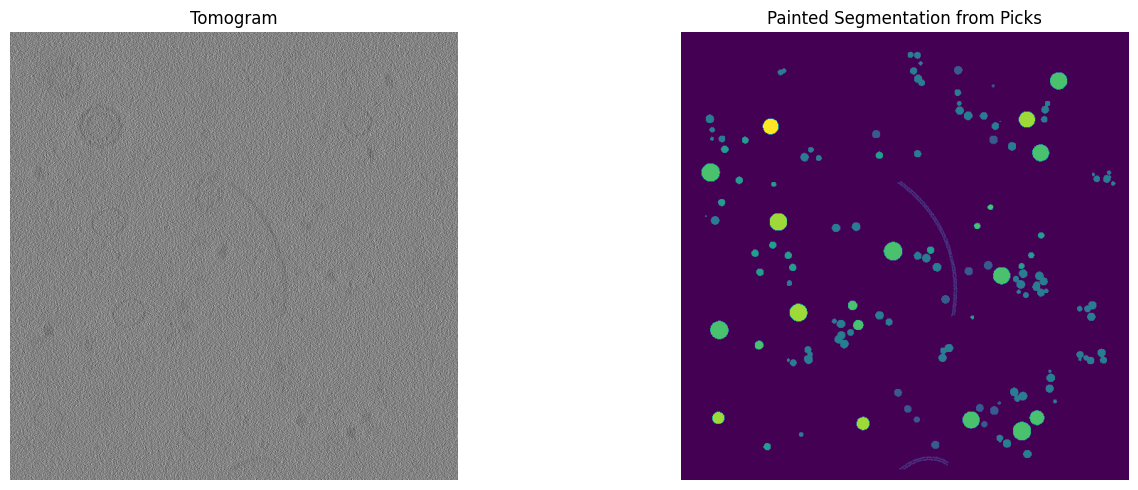

In [11]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Prepare dataloaders

In [15]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[:5], data_dicts[5:7]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Number of training samples: 5
Number of validation samples: 2


Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


## Model setup

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

cuda


In [17]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [18]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 200
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")



----------
epoch 1/200
batch 1/5, train_loss: 0.9563
batch 2/5, train_loss: 0.9532
batch 3/5, train_loss: 0.9472
batch 4/5, train_loss: 0.9418
batch 5/5, train_loss: 0.9325
epoch 1 average loss: 0.9462
----------
epoch 2/200
batch 1/5, train_loss: 0.9285
batch 2/5, train_loss: 0.9273
batch 3/5, train_loss: 0.9196
batch 4/5, train_loss: 0.9198
batch 5/5, train_loss: 0.9161
epoch 2 average loss: 0.9222
saved new best metric model
current epoch: 2 current mean recall per class: 0.03788, 0.01056, 0.02347, 0.003582, 0.3222, 0.01952, 0.008017
best mean recall: 0.0607 at epoch: 2
----------
epoch 3/200
batch 1/5, train_loss: 0.9038
batch 2/5, train_loss: 0.8937
batch 3/5, train_loss: 0.9015
batch 4/5, train_loss: 0.8887
batch 5/5, train_loss: 0.8954
epoch 3 average loss: 0.8966
----------
epoch 4/200
batch 1/5, train_loss: 0.8856
batch 2/5, train_loss: 0.8819
batch 3/5, train_loss: 0.8863
batch 4/5, train_loss: 0.8716
batch 5/5, train_loss: 0.8680
epoch 4 average loss: 0.8787
current epoch: 4

2024/10/07 20:07:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


current epoch: 200 current mean recall per class: 0, 0.3304, 0.3373, 0.3223, 0.4577, 0.5082, 0.4501
best mean recall: 0.3771 at epoch: 192


2024/10/07 20:07:29 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.19.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/07 20:07:29 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.4.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchaudio==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
/hpc/mydata/kevin.zhao/miniconda3/envs/mlchallenge/lib/python3.9/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated